# Example 3: Admittance and Coherence

The wavelet transform and scalogram are interesting on their own; however, the purpose of the `PlateFlex` software is to estimate the flexural parameters of the lithosphere from the inversion of admittance and coherence functions between topography and gravity anomaly data. We will re-use our North American example to calculate the admittance and coherence by introducing the `Project` class of `PlateFlex`.

Let's start again by loading the topography data into a `TopoGrid` object and the Bouguer gravity anomaly data into a `BougGrid` object. We also need to import the `Project` class. We also create contours of the coastline and make a mask over deep ocean basins (this will become useful in a later example).

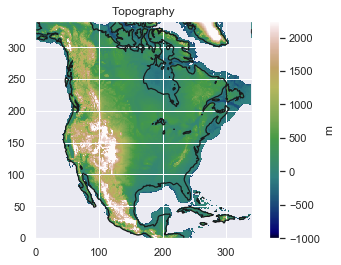

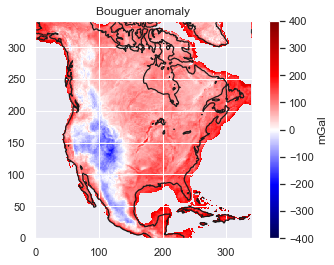

In [2]:
import numpy as np
import pandas as pd
from plateflex import TopoGrid, BougGrid, Project

# Read header (first line) of data set using pandas to get grid parameters
xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Topo_NA.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)

# Change type of nx and ny from float to integers
nx = int(nx); ny = int(ny)

# Read topography and bouguer anomaly data 
topodata = pd.read_csv('../data/Topo_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]
bougdata = pd.read_csv('../data/Bouguer_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# Load the data as `TopoGrid` and `BougGrid` objects
topo = TopoGrid(topodata, dx, dy)
boug = BougGrid(bougdata, dx, dy)

# Create contours of coastlines
contours = topo.make_contours(0.)

# Make mask over deep basins
mask = (topo.data < -500.)

# Plot topo and boug objects with mask and contours - use alternative colormaps for topo
topo.plot(mask=mask, contours=contours, cmap='gist_earth', vmin=-1000, vmax=2250)
boug.plot(mask=mask, contours=contours, cmap='seismic', vmin=-400, vmax=400)

These maps already show an obvious anti-correlation where high topography corresponds with negative Bouguer anomalies due to isostatic compensation. This relation is what we will exploit later to obtain the parameters of the flexural model.

Next we will load the two grids into a `Project` object. The simplest way to accomplish this is by listing them during initialization of the `Project` object:

In [3]:
project = Project(grids=[topo, boug])

Alternatively, the `Project` class allows you to import grids in different ways. The `Project` initialization can be performed without any `Grid` object, and those objects are added later using a simple addition or `append` method:

In [4]:
# Define empty Project
project = Project()

# Add topo
project += topo

# Add boug
project.append(boug)

You can check that the project contains the two grids, with additional attributes:

In [5]:
project.__dict__

{'inverse': 'L2',
 'grids': [<plateflex.classes.TopoGrid at 0x107adf630>,
 'mask': None,
 'initialized': False}

* `inverse` specifies the type of estimation technique for the inversion of admittance and coherence functions (this will be useful later). 
* `grids` contains a list of `Grid` objects, in this case one `TopoGrid` and one `BougGrid` object.
* `mask` is initialized as None. If updated to an array of booleans, the estimation of flexural parameters will be skipped over the masked grid cells.
* `initialized`, which defaults to `False` at the beginning. The available methods (i.e., `wlet_admit_coh` or `estimate_cell`) will not work until the project is initialized using the `init()` method

Once we are ready to proceed, we initialize the project by calling the `init()` method:

In [6]:
# Initialize Project
project.init()

<div class="alert alert-block alert-warning">
<b>Warning:</b> The project's methods (including wavelet admittance and coherence calculations) will only work if the project object contains one each of `TopoGrid` and `GravGrid` objects. Since `BougGrid` inherits from `GravGrid`, the method can proceed.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> For the calculation of the wavelet admittance and coherence, the wavelet transforms need to be calculated first, so this method can take significant time to execute.
</div>

Now we can calculate the wavelet admittance and coherence between the two grids with a simple call to the `wlet_admit_coh()` method. 

In [7]:
project.wlet_admit_coh()

You can check that new attributes have been added to the project

In [8]:
project.__dict__.keys()

dict_keys(['inverse', 'grids', 'mask', 'initialized', 'rhoc', 'zc', 'water_depth', 'k', 'ns', 'nx', 'ny', 'wl_admit', 'ewl_admit', 'wl_coh', 'ewl_coh'])

* `initialized` is now `True`
* `rhoc` and `zc` are set to `None` and will take default values set in the `plateflex.flex.conf_flex` module (see later how to change those).
* `wl_admit`, `ewl_admit`, `wl_coh`, `ewl_coh` are the wavelet admittance and error, as wavelet coherence and error.

You can even check that the individual grid attributes have been updated with the `wl_trans` attributes:

In [9]:
project.grids[0].__dict__.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'units', 'sg_units', 'logsg_units', 'title', 'ns', 'k', 'data', 'water_depth', 'wl_trans'])

You can plot the project's admittance and coherence at a specified wavenumber index using the methods `plot_admit_coh(kindex)` (with possibly other arguments):

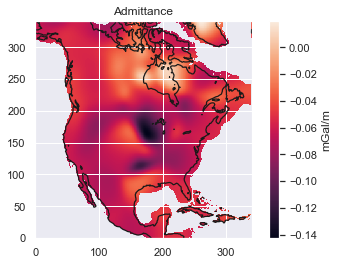

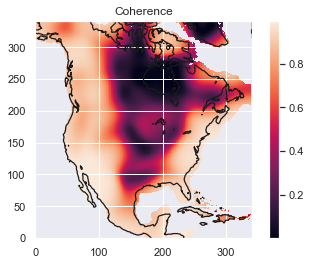

In [10]:
project.plot_admit_coh(kindex=7, contours=contours, mask=mask)

<div class="alert alert-block alert-info">
<b>Note:</b> As before with the wavelet transform and scalogram, the wavelet admittance and coherence will be calculated before plotting if the attributes are not found in the project..
</div>

With just a little bit more work, it is now possible to extract wavelet coefficients for a single grid cell and plot the admittance and coherence functions along with errors:

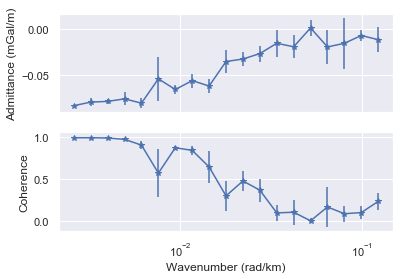

In [11]:
# Take random cell value within grid and set as attribute
project.cell = (250, 100)

# Plot admittance and coherence functions
project.plot_functions()

Now you are ready to estimate the flexural parameters! Check out Example 4.